# Simulation Validation

The aim of this notebook is to match the camera definition in sstcam-simulation to the one used in the CHEC-S prototype simtelarray configuration. This is achieved by tweaking the parameters until the SPE spectrum matches. The Charge Resolutions are then compared to confirm the performance of the two simulations match.

In [2]:
from ctapipe.io import SimTelEventSource
from ctapipe.image.extractor import extract_around_peak, integration_correction
from sstcam_simulation import Camera, SSTCameraMapping, PhotoelectronSource, EventAcquisition
from sstcam_simulation.camera.spe import SiPMGentileSPE, PerfectPhotosensor
from sstcam_simulation.camera.pulse import GenericPulse
from sstcam_simulation.camera.noise import GaussianNoise
from CHECLabPy.core.io import HDF5Writer, HDF5Reader
from CHECLabPy.spectrum_fitters import SpectrumParameter, SiPMGentileFitter as GentileFitter
from CHECLabPy.utils.resolutions import ChargeResolution
from glob import glob
import re
from tqdm.auto import tqdm, trange
import numpy as np
from numpy.polynomial.polynomial import polyfit, polyval
import pandas as pd
from scipy import interpolate
from scipy.ndimage import correlate1d
from matplotlib import pyplot as plt

%matplotlib inline

# Preparation

In [5]:
runlist_path = "/Volumes/gct-jason/sim_telarray/d180907_dynrange/opct40/40MHz/runlist.txt"
runlist = pd.read_csv(runlist_path, delimiter=' ', index_col=0, comment='#')

In [6]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [atoi(c) for c in re.split('(\d+)', text)]


def sort_file_list(file_list):
    file_list.sort(key=natural_keys)
    return file_list

In [282]:
simtel_0MHz_paths = sort_file_list(glob("/Volumes/gct-jason/sim_telarray/d180907_dynrange/opct40/0MHz/*.simtel.gz"))
simtel_40MHz_paths = sort_file_list(glob("/Volumes/gct-jason/sim_telarray/d180907_dynrange/opct40/40MHz/*.simtel.gz"))

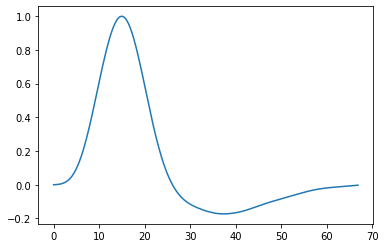

In [283]:
# Obtain reference pulse shape from simtel file
simtel_source = SimTelEventSource(input_url=simtel_40MHz_paths[0])
ref_x = simtel_source.subarray.tel[1].camera.readout.reference_pulse_sample_time.to_value('ns')
ref_y = simtel_source.subarray.tel[1].camera.readout.reference_pulse_shape[0]
ref_width = simtel_source.subarray.tel[1].camera.readout.reference_pulse_sample_width.to_value('ns')
plt.plot(ref_x, ref_y)

for event in simtel_source:
    example_waveforms = event.r1.tel[1].waveform
    n_pixels, n_samples = event.r1.tel[1].waveform.shape    
    break

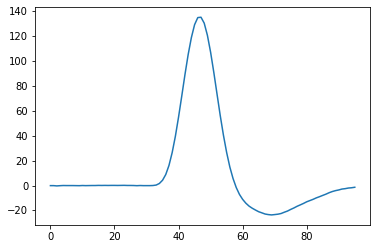

In [284]:
plt.plot(example_waveforms[0])

In [285]:
class ChargeExtractor:
    def __init__(self, ref_x, ref_y, ref_width, example_waveforms, window_width=8, window_shift=3):
        self.ref_x = ref_x
        self.ref_y = ref_y
        self.window_width = window_width
        self.window_shift = window_shift
        
        # Integration window correction
        self.correction = integration_correction(ref_y[None, :], ref_width, 1, window_width, window_shift)
        
        # Prepare for cc
        f = interpolate.interp1d(ref_x, ref_y, kind=3)
        cc_ref_x = np.arange(0, ref_x[-1], 1)
        cc_ref_y = f(cc_ref_x)
        y_1pe = cc_ref_y / np.trapz(cc_ref_y)
        self.origin = cc_ref_y.argmax() - cc_ref_y.size // 2
        scale = correlate1d(y_1pe, cc_ref_y, mode='constant', origin=self.origin).max()
        self.cc_ref_y = cc_ref_y / scale
        
        # Fix integration start and width
        self.window_peak_index = self._get_window_peak_index(example_waveforms)
        self.cc_peak_index = self._get_cc_peak_index(example_waveforms)
        
    def _get_window_peak_index(self, waveforms):
        return waveforms.mean(axis=0).argmax()
    
    def _get_cc(self, waveforms):
        return correlate1d(waveforms, self.cc_ref_y, mode='constant', origin=self.origin)
    
    def _get_cc_peak_index(self, waveforms):
        cc = self._get_cc(waveforms)
        return cc.mean(axis=0).argmax()
        
    def extract_window(self, waveforms):
        start = self.window_peak_index - self.window_shift
        charge, _ = extract_around_peak(waveforms, start, self.window_width, 0, 1)
        return charge * self.correction
    
    def extract_cc(self, waveforms):
        cc = self._get_cc(waveforms)
        charge = cc[:, self.cc_peak_index]
        return charge

extractor = ChargeExtractor(ref_x, ref_y, ref_width, example_waveforms)

# Extract from simtel files

In [286]:
def extract_from_simtel_list(paths, max_events=None):
    df_list = []
    poi = 888
    pixel_array = np.arange(n_pixels)
    for path in tqdm(paths, total=len(paths)):
        regex = re.search(r".*run(\d+).simtel.gz", path)
        run = int(regex.group(1))
        illumination = runlist.loc[run, 'pe_expected']
        simtel_source = SimTelEventSource(input_url=path, max_events=max_events)
        for event in tqdm(simtel_source):
            iev = event.count
            waveforms = event.r1.tel[1].waveform
            true_pe = event.mc.tel[1].photo_electron_image
            true_charge = np.nan
            charge_window = extractor.extract_window(waveforms)
            charge_cc = extractor.extract_cc(waveforms)

            df_list.append(pd.DataFrame(dict(
                illumination=illumination,
                iev=iev,
                ipix=[poi],
                true_pe=true_pe[poi],
                true_charge=true_charge,
                charge_window=charge_window[poi],
                charge_cc=charge_cc[poi],
            )))
    return pd.concat(df_list, ignore_index=True)

In [287]:
simtel_spe_scan = extract_from_simtel_list(simtel_0MHz_paths)
with HDF5Writer("simtel_spe_scan.h5") as writer:
    writer.write(data=simtel_spe_scan)



Creating HDF5 file: simtel_spe_scan.h5
Saving metadata to HDF5 file


(-0.5, 4)

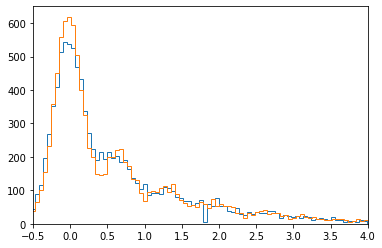

In [108]:
spe_df = simtel_spe_scan.loc[simtel_spe_scan['illumination'] == simtel_spe_scan['illumination'].min()]
_ = plt.hist(spe_df['charge_window'], bins=200, histtype='step')
_ = plt.hist(spe_df['charge_cc'], bins=200, histtype='step')
#_ = plt.hist(spe_df['true_pe'], bins=200, histtype='step')
#_ = plt.hist(spe_df['true_charge'], bins=200, histtype='step')
plt.xlim([-0.5, 4])

In [16]:
simtel_dynamic_scan = extract_from_simtel_list(simtel_40MHz_paths[::3], max_events=100)
with HDF5Writer("simtel_dynamic_scan.h5") as writer:
    writer.write(data=simtel_dynamic_scan)



Creating HDF5 file: simtel_dynamic_scan.h5
Saving metadata to HDF5 file


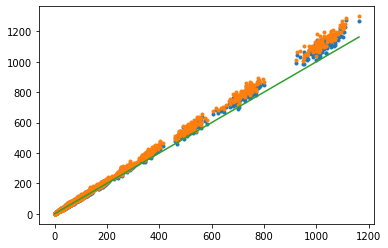

In [17]:
plt.plot(simtel_dynamic_scan['true_pe'], simtel_dynamic_scan['charge_window'], '.')
plt.plot(simtel_dynamic_scan['true_pe'], simtel_dynamic_scan['charge_cc'], '.')
plt.plot([0, simtel_dynamic_scan['true_pe'].max()], [0, simtel_dynamic_scan['true_pe'].max()])

# Define Simulation

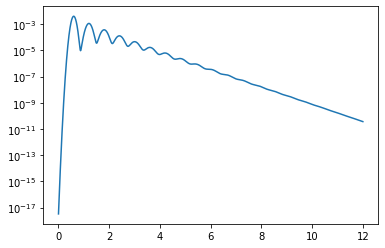

In [18]:
photoelectron_spectrum = SiPMGentileSPE(x_max=20, spe_sigma=0.12, opct=0.4)
plt.semilogy(photoelectron_spectrum.x, photoelectron_spectrum.pdf)
#plt.xlim([0, 3])
#plt.ylim([1e-4, None])

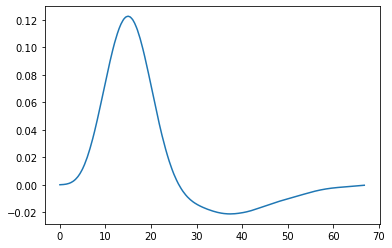

In [19]:
reference_pulse = GenericPulse(ref_x, ref_y)
plt.plot(reference_pulse.time, reference_pulse.pulse)

In [20]:
camera = Camera(
    photoelectron_spectrum=photoelectron_spectrum,
    reference_pulse=reference_pulse,
    mapping=SSTCameraMapping(n_pixels=1),
    n_waveform_samples=n_samples,
    continuous_readout_duration=n_samples,
    electronic_noise=GaussianNoise(stddev=0.15),
)

# Run Simulation

In [21]:
def simulate_scan(camera, nsb_rate, illuminations, n_events):
    source = PhotoelectronSource(camera=camera)
    acquisition = EventAcquisition(camera=camera)
    df_list = []
    pixel_array = np.arange(camera.mapping.n_pixels)
    for illumination in tqdm(illuminations):
        for iev in range(n_events):
            nsb_pe = source.get_nsb(nsb_rate)
            signal_pe = source.get_uniform_illumination(time=extractor.window_peak_index, illumination=illumination)
            pe = nsb_pe + signal_pe
            readout = acquisition.get_continuous_readout(pe)
            waveforms = acquisition.get_sampled_waveform(readout)
            true_pe = signal_pe.get_photoelectrons_per_pixel(camera.mapping.n_pixels)
            true_charge = signal_pe.get_charge_per_pixel(camera.mapping.n_pixels)
            charge_window = extractor.extract_window(waveforms)
            charge_cc = extractor.extract_cc(waveforms)

            df_list.append(pd.DataFrame(dict(
                illumination=illumination,
                iev=iev,
                ipix=pixel_array,
                true_pe=true_pe,
                true_charge=true_charge,
                charge_window=charge_window,
                charge_cc=charge_cc,
            )))

    return pd.concat(df_list, ignore_index=True)

In [22]:
sim_spe_scan = simulate_scan(camera, 0, [1, 0.8, 0.6], 10000)
with HDF5Writer("sim_spe_scan.h5") as writer:
    writer.write(data=sim_spe_scan)


Creating HDF5 file: sim_spe_scan.h5
Saving metadata to HDF5 file


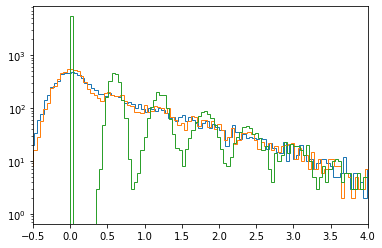

In [23]:
spe_df = sim_spe_scan.loc[sim_spe_scan['illumination'] == sim_spe_scan['illumination'].min()]
_ = plt.hist(spe_df['charge_window'], bins=200, histtype='step')
_ = plt.hist(spe_df['charge_cc'], bins=200, histtype='step')
#_ = plt.hist(spe_df['true_pe'], bins=200, histtype='step')
_ = plt.hist(spe_df['true_charge'], bins=200, histtype='step')
plt.xlim([-0.5, 4])
plt.yscale('log')

In [24]:
sim_dynamic_scan = simulate_scan(camera, 40, np.logspace(-1, 3, 100), 100)
with HDF5Writer("sim_dynamic_scan.h5") as writer:
    writer.write(data=sim_dynamic_scan)


Creating HDF5 file: sim_dynamic_scan.h5
Saving metadata to HDF5 file


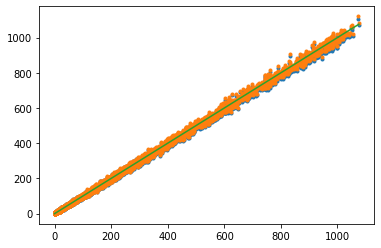

In [25]:
plt.plot(sim_dynamic_scan['true_pe'], sim_dynamic_scan['charge_window'], '.')
plt.plot(sim_dynamic_scan['true_pe'], sim_dynamic_scan['charge_cc'], '.')
plt.plot([0, sim_dynamic_scan['true_pe'].max()], [0, sim_dynamic_scan['true_pe'].max()])

# SPE Fitting

In [3]:
with HDF5Reader("simtel_spe_scan.h5") as reader:
    simtel_spe_scan = reader.read('data')

Opening HDF5 file: simtel_spe_scan.h5
Reading entire DataFrame (data) from HDF5 file into memory


In [4]:
with HDF5Reader("sim_spe_scan.h5") as reader:
    sim_spe_scan = reader.read('data')

Opening HDF5 file: sim_spe_scan.h5
Reading entire DataFrame (data) from HDF5 file into memory


In [5]:
fitter = GentileFitter(n_illuminations=3)
fitter.parameters.update([
    SpectrumParameter("spe", 0.1, (0.2, 1.5)),
    SpectrumParameter("spe_sigma", 0.1, (0.01, 1)),
    SpectrumParameter("eped", 0, (-1, 1)),
    SpectrumParameter("eped_sigma", 0.1, (0.0001, 1)),
])
fitter.parameters.spe_sigma.limits

(0.01, 1)

In [6]:
def extract_spe(df):
    illuminations = []
    charges = []
    for illumination, group in df.groupby("illumination"):
        charge = group['charge_cc'].values
        illuminations.append(illumination)
        charges.append(charge)

    fitter = GentileFitter(n_illuminations=len(charges))
    fitter.range = [-1, 6]
    fitter.n_bins = 80
    fitter.parameters.update([
        SpectrumParameter("spe", 1, (0.2, 1.5)),
        SpectrumParameter("spe_sigma", 0.1, (0.01, 1)),
        SpectrumParameter("eped", 0, (-1, 1)),
        SpectrumParameter("eped_sigma", 0.1, (0.0001, 1)),
    ])
    fitter.apply(*charges)
    
    fit_result_values = fitter.fit_result_values
    fit_result_errors = fitter.fit_result_errors
    hist_x, hist_y, hist_edges = fitter.charge_histogram
    fit_x, fit_y = fitter.fit_result_curve

    lambdas = []
    lambdas_err = []
    for i in range(fitter.n_illuminations):
        color = plt.gca()._get_lines.get_next_color()
        plt.hist(hist_x, bins=hist_edges, weights=hist_y[i], histtype='step', color=color)
        plt.plot(fit_x, fit_y[i], color=color)
        #plt.yscale("log")
        #plt.ylim([1e-2, None])

        avg = np.mean(charges[i])
        #avg = np.average(fitter.between, weights=fitter.hist[i])
        lambda_ = fit_result_values[f'lambda_{i}']
        lambdas.append(lambda_)
        lambdas_err.append(fit_result_errors[f'lambda_{i}'])
        print("Gain = ", avg/lambda_)

    print(fit_result_values)
    print(fit_result_errors)
    
    return np.array(illuminations), np.array(lambdas), np.array(lambdas_err)

Gain =  1.1061082597296907
Gain =  1.0850054846909023
Gain =  1.0738521395152536
Gain =  1.0718752449837727
Gain =  1.0911667925769208
<ValueView of Minuit at 7fa7a0aa1830>
  eped: -0.01358885668681531
  eped_sigma: 0.19235374154306598
  spe: 0.6560774370801882
  spe_sigma: 0.07808673138220955
  opct: 0.4033028165020673
  lambda_0: 0.5314579015763983
  lambda_1: 0.59904864728918
  lambda_2: 0.8295465806376017
  lambda_3: 1.0167096764242058
  lambda_4: 1.4087469769046603
<ErrorView of Minuit at 7fa7a0aa1830>
  eped: 0.0016707830281023628
  eped_sigma: 0.0011518086931752158
  spe: 0.0021642341439169765
  spe_sigma: 0.0033611140715240073
  opct: 0.0037043363440959487
  lambda_0: 0.008494894913905038
  lambda_1: 0.009047483142621993
  lambda_2: 0.010943088410929391
  lambda_3: 0.01241955301998443
  lambda_4: 0.015366065115806293


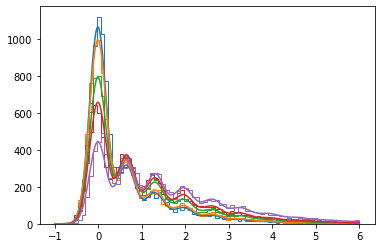

In [7]:
illumination, lambda_, lambda_err = extract_spe(simtel_spe_scan)
simtel_spe_scan_c, simtel_spe_scan_m = polyfit(illumination, lambda_, 1, w=1/lambda_err)

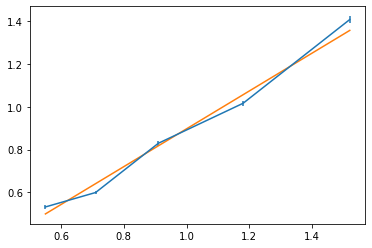

In [8]:
plt.errorbar(illumination, lambda_, yerr=lambda_err)
plt.plot(illumination, polyval(illumination, (simtel_spe_scan_c, simtel_spe_scan_m)))

Gain =  1.008592927854827
Gain =  1.003168005540458
Gain =  0.9992405765467512
<ValueView of Minuit at 7fb054188a40>
  eped: 0.0041554716645806344
  eped_sigma: 0.18153381926193174
  spe: 0.5940965179966796
  spe_sigma: 0.06848013227096648
  opct: 0.40682196592545156
  lambda_0: 0.5980690172640146
  lambda_1: 0.7743061345978457
  lambda_2: 0.9964586628114204
<ErrorView of Minuit at 7fb054188a40>
  eped: 0.002092449289995968
  eped_sigma: 0.00145303588055809
  spe: 0.002722622570450861
  spe_sigma: 0.0048260479934339184
  opct: 0.004631674999645202
  lambda_0: 0.009371056519172749
  lambda_1: 0.010935259051142565
  lambda_2: 0.012753700561262682


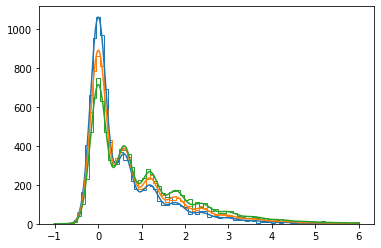

In [458]:
illumination, lambda_, lambda_err = extract_spe(sim_spe_scan)
sim_spe_scan_c, sim_spe_scan_m = polyfit(illumination, lambda_, 1, w=1/lambda_err)

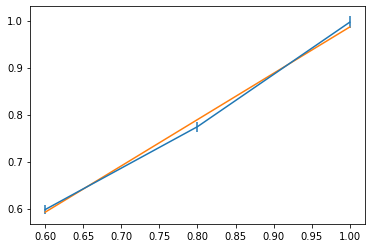

In [459]:
plt.errorbar(illumination, lambda_, yerr=lambda_err)
plt.plot(illumination, polyval(illumination, (sim_spe_scan_c, sim_spe_scan_m)))

# Charge Resolution

Opening HDF5 file: simtel_dynamic_scan.h5
Reading entire DataFrame (data) from HDF5 file into memory


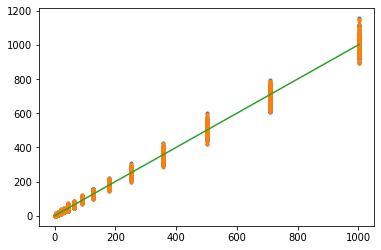

In [460]:
with HDF5Reader("simtel_dynamic_scan.h5") as reader:
    simtel_dynamic_scan = reader.read('data')
    
# Calibrate
simtel_dynamic_scan['illumination'] = polyval(simtel_dynamic_scan['illumination'], (simtel_spe_scan_c, simtel_spe_scan_m))

c, m = polyfit(simtel_dynamic_scan['illumination'], simtel_dynamic_scan['charge_window'], 1)
simtel_dynamic_scan['charge_window'] = (simtel_dynamic_scan['charge_window'] - c) / m
c, m = polyfit(simtel_dynamic_scan['illumination'], simtel_dynamic_scan['charge_cc'], 1)
simtel_dynamic_scan['charge_cc'] = (simtel_dynamic_scan['charge_cc'] - c) / m

plt.plot(simtel_dynamic_scan['illumination'], simtel_dynamic_scan['charge_window'], '.')
plt.plot(simtel_dynamic_scan['illumination'], simtel_dynamic_scan['charge_cc'], '.')
plt.plot([0, simtel_dynamic_scan['illumination'].max()], [0, simtel_dynamic_scan['illumination'].max()])


# c, m = polyfit(simtel_dynamic_scan['true_pe'], simtel_dynamic_scan['charge_window'], [1])
# simtel_dynamic_scan['charge_window'] /= m
# c, m = polyfit(simtel_dynamic_scan['true_pe'], simtel_dynamic_scan['charge_cc'], [1])
# simtel_dynamic_scan['charge_cc'] /= m

# plt.plot(simtel_dynamic_scan['true_pe'], simtel_dynamic_scan['charge_window'], '.')
# plt.plot(simtel_dynamic_scan['true_pe'], simtel_dynamic_scan['charge_cc'], '.')
# plt.plot([0, simtel_dynamic_scan['true_pe'].max()], [0, simtel_dynamic_scan['true_pe'].max()])

Opening HDF5 file: sim_dynamic_scan.h5
Reading entire DataFrame (data) from HDF5 file into memory


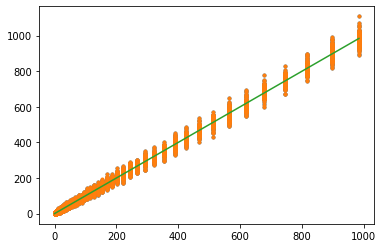

In [461]:
with HDF5Reader("sim_dynamic_scan.h5") as reader:
    sim_dynamic_scan = reader.read('data')
    
# Calibrate
sim_dynamic_scan['illumination'] = polyval(sim_dynamic_scan['illumination'], (sim_spe_scan_c, sim_spe_scan_m))

c, m = polyfit(sim_dynamic_scan['illumination'], sim_dynamic_scan['charge_window'], 1)
sim_dynamic_scan['charge_window'] = (sim_dynamic_scan['charge_window'] - c) / m
c, m = polyfit(sim_dynamic_scan['illumination'], sim_dynamic_scan['charge_cc'], 1)
sim_dynamic_scan['charge_cc'] = (sim_dynamic_scan['charge_cc'] - c) / m

plt.plot(sim_dynamic_scan['illumination'], sim_dynamic_scan['charge_window'], '.')
plt.plot(sim_dynamic_scan['illumination'], sim_dynamic_scan['charge_cc'], '.')
plt.plot([0, sim_dynamic_scan['illumination'].max()], [0, sim_dynamic_scan['illumination'].max()])

# c, m = polyfit(sim_dynamic_scan['true_pe'], sim_dynamic_scan['charge_window'], [1])
# sim_dynamic_scan['charge_window'] /= m
# c, m = polyfit(sim_dynamic_scan['true_pe'], sim_dynamic_scan['charge_cc'], [1])
# sim_dynamic_scan['charge_cc'] /= m

# plt.plot(sim_dynamic_scan['true_pe'], sim_dynamic_scan['charge_window'], '.')
# plt.plot(sim_dynamic_scan['true_pe'], sim_dynamic_scan['charge_cc'], '.')
# plt.plot([0, sim_dynamic_scan['true_pe'].max()], [0, sim_dynamic_scan['true_pe'].max()])

In [462]:
def bin_charge_resolution(df, n_bins=40):
    true = df['true'].values
    min_ = true.min()
    max_ = (true.max() // 500 + 1) * 500
    bins = np.geomspace(0.1, max_, n_bins)
    bins = np.append(bins, 10**(np.log10(bins[-1]) + np.diff(np.log10(bins))[0]))
    df['bin'] = np.digitize(true, bins, right=True) - 1

    log = np.log10(bins)
    between = 10**((log[1:] + log[:-1]) / 2)
    edges = np.repeat(bins, 2)[1:-1].reshape((bins.size-1 , 2))
    edge_l = edges[:, 0]
    edge_r = edges[:, 1]
    df['between'] = between[df['bin']]
    df['edge_l'] = edge_l[df['bin']]
    df['edge_r'] = edge_r[df['bin']]

    return df

In [463]:
def get_charge_resolution(df, charge_column):
#     charge_resolution = ChargeResolution(mc_true=False)
#     charge_resolution.add(df['ipix'], df['illumination'], df[charge_column])
    
    charge_resolution = ChargeResolution(mc_true=True)
    charge_resolution.add(df['ipix'], df['true_pe'], df[charge_column])
    
    res, _ = charge_resolution.finish()
    res = bin_charge_resolution(res, n_bins=20)
    res = res.groupby('bin').mean()
    x = res['true'].values
    y = res['charge_resolution'].values

    return x, y

In [464]:
def limit_curves(n, nsb, t_w, n_e, sigma_g, enf, pde):
    q = n * pde
    sigma_0 = np.sqrt(nsb * t_w + n_e**2)
    sigma_enf = 1 + enf
    sigma_q = np.sqrt(sigma_0**2 + sigma_enf**2 * q + sigma_g**2 * q**2)
    return sigma_q / q

In [465]:
def requirement(n):
    nsb = 0.125
    t_w = 15
    n_e = 0.87
    sigma_g = 0.1
    enf = 0.2
    pde = 1#0.25
    lc = limit_curves
    requirement = lc(n, nsb, t_w, n_e, sigma_g, enf, pde)

    max_photons = 4000
    min_photons = 4
    requirement[(n > max_photons) & (n < min_photons)] = np.nan

    return requirement

In [466]:
cr_simtel_window_x, cr_simtel_window_y = get_charge_resolution(simtel_dynamic_scan, "charge_window")
cr_simtel_cc_x, cr_simtel_cc_y = get_charge_resolution(simtel_dynamic_scan, "charge_cc")
cr_sim_window_x, cr_sim_window_y = get_charge_resolution(sim_dynamic_scan, "charge_window")
cr_sim_cc_x, cr_sim_cc_y = get_charge_resolution(sim_dynamic_scan, "charge_cc")

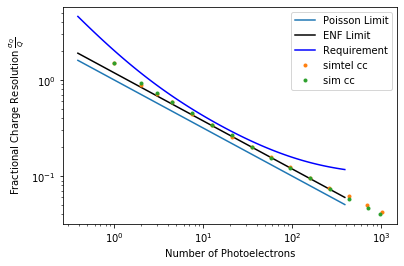

In [467]:
x = np.geomspace(1, 1000, 100) * 0.39
poisson_limit = np.sqrt(x) / x
enf_limit = np.sqrt(camera.photoelectron_spectrum.excess_noise_factor * x) / x
requirement_limit = requirement(x) 
plt.plot(x, poisson_limit, label="Poisson Limit")
plt.plot(x, enf_limit, label="ENF Limit", color='black')
plt.plot(x, requirement_limit, label="Requirement", color='blue')

# plt.plot(cr_simtel_window_x, cr_simtel_window_y, '.', label="simtelarray")
plt.plot(cr_simtel_cc_x, cr_simtel_cc_y, '.', label="simtel cc")
# plt.plot(cr_sim_window_x, cr_sim_window_y, '.', label="sstcam-simulation")
plt.plot(cr_sim_cc_x, cr_sim_cc_y, '.', label="sim cc")

plt.legend(loc="best")
plt.xlabel("Number of Photoelectrons")
plt.ylabel(r"Fractional Charge Resolution $\frac{{\sigma_Q}}{{Q}}$")
plt.xscale('log')
plt.yscale('log')